### *ETL Of Online Retail Dataset*

### *Configuration and Setup*

In this cell, the necessary Python libraries for data processing and database interaction are imported. Key configuration variables are also defined:

- `DB_FILE`: Specifies the name of the SQLite database file where the transformed data will be stored.
- `EXCEL_FILE`: Specifies the name of the Excel file containing the raw Online Retail dataset.
- `CURRENT_DATE`: Sets a fixed current date for filtering transactions in the transformation stage, as required for the

In [ ]:
# Importing necessary libraries
import pandas as pd
import sqlite3
from datetime import datetime

# Configurations
DB_FILE = "retail_dw.db" # defining the SQLite database file name
EXCEL_FILE = "Online Retail.xlsx"  # defining the Excel file name
CURRENT_DATE = pd.Timestamp("2011-08-12")  # Fixed current date for exam requirement


### *Extraction stage*
In this step, we load the Online Retail dataset from an Excel file (.xlsx) into a pandas DataFrame.
We also inspect the structure of the data, check for missing values, and ensure columns like InvoiceDate are converted to the correct data type (datetime).
This is the foundation for all later transformations.

In [5]:
def extract_data(file_path):
    """
    Reads the Online Retail Excel into a DataFrame.
    Handles missing values and ensures correct data types.
    """
    print("Extracting data...")
    
    # Reading the Excel
    df = pd.read_excel(file_path)
    print(f"Initial rows extracted: {len(df)}")
    
    # Dropping rows with missing CustomerID
    df = df.dropna(subset=["CustomerID"])
    
    # Converting InvoiceDate to datetime
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    
    return df

# Running extraction
df_raw = extract_data(EXCEL_FILE)
df_raw.head()


Extracting data...
Initial rows extracted: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### *Transformation stage*

In  this cell, the transformation process is performed on the extracted retail dataset. The steps include:

- Filtering out records with non-positive quantity or unit price.
- Calculating the total sales for each transaction.
- Selecting only transactions from the last year based on the configured date.
- Creating a customer dimension table summarizing total purchases and country for each customer.
- Creating a time dimension table with unique invoice dates and related time attributes (date, month, quarter, year).
- Returning the cleaned fact table and the two dimension tables for further loading into into the data warehouse.

In [6]:
def transform_data(df):
    print("Transforming data...")
    df = df.copy()  # Creating a copy to avoid modifying the original DataFrame
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
    df["TotalSales"] = df["Quantity"] * df["UnitPrice"]
    one_year_ago = CURRENT_DATE - pd.DateOffset(years=1)
    df_last_year = df[df["InvoiceDate"] >= one_year_ago]
    
    # Creating CustomerDim
    customer_summary = (
        df_last_year.groupby("CustomerID") # Grouping by CustomerID
        .agg(
            TotalPurchases=("TotalSales", "sum"),
            Country=("Country", "first")
        )# Aggregating to get total purchases and country
        .reset_index()# Resetting index to flatten the DataFrame
    )
    
    # Creating TimeDim
    time_dim = (
        df_last_year[["InvoiceDate"]] # Selecting only InvoiceDate for time dimension
        .drop_duplicates() # Dropping duplicates to get unique dates
        .assign(
            TimeID=lambda x: x["InvoiceDate"].rank(method="dense").astype(int),
            Date=lambda x: x["InvoiceDate"].dt.date,
            Month=lambda x: x["InvoiceDate"].dt.month,
            Quarter=lambda x: x["InvoiceDate"].dt.quarter,
            Year=lambda x: x["InvoiceDate"].dt.year
        ) # Creating additional time attributes
    )
    
    print(f"Rows after cleaning/filtering: {len(df_last_year)}") # Displaying the number of rows after filtering
    
    return df_last_year, customer_summary, time_dim # Returning the cleaned fact table and dimension tables

# Run transformation
df_fact, df_customer, df_time = transform_data(df_raw) # Displaying the transformed fact table and dimension tables
df_fact.head()

Transforming data...
Rows after cleaning/filtering: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### *Load stage*

In this cell, the transformed fact and dimension tables are loaded into a SQLite database. The process involves:

- Establishing a connection to the SQLite database file.
- Writing the fact table (`SalesFact`) and the dimension tables (`CustomerDim` and `TimeDim`) into the database, replacing any existing tables with the same names.
- Closing the database connection after the load is complete.
- Printing status messages to indicate the progress and completion of the loading
- Running the load into a db file

In [7]:
def load_to_sqlite(df_fact, df_customer, df_time, db_file):
    """
    Loads fact and dimension tables into SQLite database.
    """
    print("Loading into SQLite database...")
    
    conn = sqlite3.connect(db_file) # Establishing connection to the SQLite database
    
    df_fact.to_sql("SalesFact", conn, if_exists="replace", index=False)# Writing the fact table to the database
    df_customer.to_sql("CustomerDim", conn, if_exists="replace", index=False)# Writing the customer dimension table to the database
    df_time.to_sql("TimeDim", conn, if_exists="replace", index=False)# Writing the time dimension table to the database
    
    conn.close()# Closing the database connection
    print("Load complete.")# Displaying load completion message

# Running load
load_to_sqlite(df_fact, df_customer, df_time, DB_FILE)


Loading into SQLite database...
Load complete.


### *Full ETL Process Function*

This cell defines and runs the `run_full_etl` function, which executes the entire ETL workflow. It prints the number of rows in the original dataset, the number of rows after filtering for the last year, and the number of rows in the customer dimension table. This provides a quick summary of the ETL process and helps verify that each major step has completed successfully.

In [8]:
def run_full_etl(df_raw):
    print("\n--- Running Full ETL Process ---")# Displaying the start of the ETL process
    df_fact, customer_summary, df_time = transform_data(df_raw)
    print(f"Rows in original dataset: {df_raw.shape[0]}")# Displaying the number of rows in the original dataset
    print(f"Rows after last year filter: {df_fact.shape[0]}")# Displaying the number of rows after filtering for the last year
    print(f"Rows in CustomerDim: {customer_summary.shape[0]}")# Displaying the number of rows in the customer dimension table
    print("--- ETL Process Completed ---")# Displaying the completion of the ETL process

# Runing the full ETL process
run_full_etl(df_raw)


--- Running Full ETL Process ---
Transforming data...
Rows after cleaning/filtering: 397884
Rows in original dataset: 406829
Rows after last year filter: 397884
Rows in CustomerDim: 4338
--- ETL Process Completed ---


### *Year and Month Extraction*

This cell adds two new columns to the transformed fact table (`df_fact`): `Year` and `Month`, which are extracted from the `InvoiceDate` column. These columns are useful for time-based analysis and aggregations in later steps.

In [9]:
# Extract Year and Month from InvoiceDate
df_fact["Year"] = df_fact["InvoiceDate"].dt.year
df_fact["Month"] = df_fact["InvoiceDate"].dt.month

### *Country Sales Roll-up*

This cell calculates the total sales for each country by grouping the fact table (`df_fact`) by the `Country` column and summing the `TotalSales`. The results are sorted in descending order to show the countries with the highest sales first.

In [10]:
# Roll-up: Total sales per country
rollup_country = df_fact.groupby("Country")["TotalSales"].sum().reset_index()
rollup_country.sort_values(by="TotalSales", ascending=False, inplace=True)
rollup_country
# Displaying the roll-up of total sales per country

,Country,TotalSales
35,United Kingdom,7308391.554
23,Netherlands,285446.340
10,EIRE,265545.900
14,Germany,228867.140
13,France,209024.050
0,Australia,138521.310
30,Spain,61577.110
32,Switzerland,56443.950
3,Belgium,41196.340
31,Sweden,38378.330


### *Country and Month Sales Drill-down*

This cell performs a drill-down analysis by calculating total sales for each country and each month. It groups the fact table by both `Country` and `Month`, sums the `TotalSales`, and sorts the results for detailed time-based country sales insights.

In [11]:
# Drill-down: Total sales per country per month
drilldown_country_month = df_fact.groupby(["Country", "Month"])["TotalSales"].sum().reset_index()
drilldown_country_month.sort_values(by=["Country", "Month"], inplace=True)
drilldown_country_month
# Displaying the drill-down of total sales per country per month

,Country,Month,TotalSales
0,Australia,1,9017.71
1,Australia,2,14695.42
2,Australia,3,17223.99
3,Australia,4,771.60
4,Australia,5,13638.41
...,...,...,...
266,Unspecified,4,299.10
267,Unspecified,5,852.68
268,Unspecified,6,185.78
269,Unspecified,7,798.48


### *United Kingdom Data Slice*

This cell filters the fact table (`df_fact`) to show only transactions from the United Kingdom. It displays the first few rows of this subset, allowing focused analysis on UK

In [12]:
# Slice: Data only for United Kingdom
slice_uk = df_fact[df_fact["Country"] == "United Kingdom"]
slice_uk.head()
# Displaying the slice of data for the United Kingdom

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Year,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12


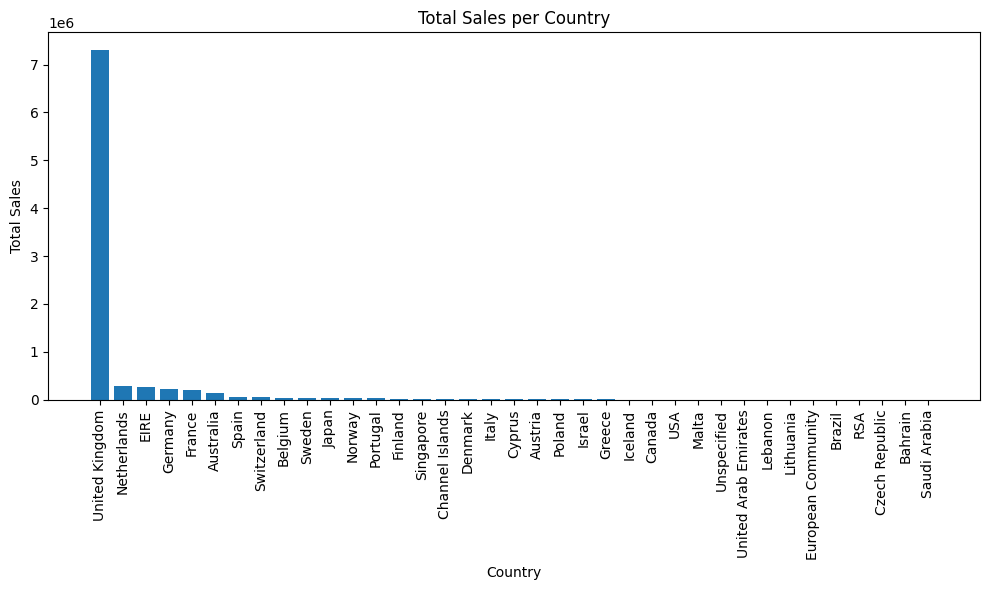

In [13]:
import matplotlib.pyplot as plt

# Visualization for Roll-Up by Country
plt.figure(figsize=(10, 6))
plt.bar(rollup_country["Country"], rollup_country["TotalSales"])
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.title("Total Sales per Country")
plt.tight_layout()
plt.show()
